In [1]:
from sklearn.model_selection import train_test_split, KFold
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from keras.models import Model
from keras.layers import Input, LSTM, Flatten, Dense, Dropout, Embedding, Concatenate,MaxPooling1D,concatenate 
from keras.optimizers import Adam, SGD
import tensorflow as tf
import nltk 
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from numpy import zeros

c:\Python39\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.0.0)/charset_normalizer (2.0.9) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
#Hyper Parameters
FILE_NAME = "../../Data/processed_data.csv"
DENSE_LAYER_SIZE =50
BATCH_SIZE = 32
EPOCH_LENGTH = 10
VALIDATION_PERCENTAGE = 0.1
TEST_SIZE_PERCENTAGE = 0.2
NUMBER_K_FOLDS = 3
LEARNING_RATE = 0.1
VERBOSE = 1
MAX_LENGTH = 20
HIDDEN_ACTIVATION_FUNCTION = 'relu'
OUTPUT_ACTIVATION_FUNCTION = 'softmax'
LOSS_FUNCTION = 'categorical_crossentropy'
METRICS=['accuracy']
Y_LABEL_NAME="author"
X_LABEL_NAME="text"

In [3]:
#Read data
data = pd.read_csv(FILE_NAME)

In [4]:
documents = data[X_LABEL_NAME]
tokenizer = Tokenizer()

In [6]:
tokenizer.fit_on_texts(documents)
vocab_size = len(tokenizer.word_index) + 1

In [8]:
encoded_docs = tokenizer.texts_to_sequences(documents)


In [10]:
padded_docs = pad_sequences(encoded_docs, maxlen=MAX_LENGTH, padding='post')
print(padded_docs)

[[  294     4     1 ...    98     1   429]
 [   11    89   125 ...     0     0     0]
 [  560  3702    32 ...   345   476  2690]
 ...
 [10408  5067 15798 ...     0     0     0]
 [   17    34  4660 ...     0     0     0]
 [    6  6667  6561 ...     9     2  6006]]


In [72]:
max_length_for_padding=[] 
for i in encoded_docs:  
  max_length_for_padding.append(len(i))  
print(max(max_length_for_padding))

861


In [73]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('../embeddings/glove.6B.100d.txt',encoding="utf8")
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [74]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [75]:

#Defining model
def define_model(input_size, output_size, verbose = True, dense_layer_size = 50,
                 hidden_activation_fn = 'relu', output_activation_fn='softmax',
                 learning = 0.0005, loss_function = 'categorical_crossentropy', metrics = ['accuracy']):
    

    # define model
    input =  Input(shape=(input_size,))
    emb_lay = Embedding(vocab_size, 100,weights=[embedding_matrix], input_length=MAX_LENGTH, trainable=True)(input)
    dense = Dense(dense_layer_size, activation=hidden_activation_fn)(emb_lay)
    flat1 = Flatten()(dense)
    output=Dense(units=output_size, activation=output_activation_fn)(flat1)

    # Create model
    model = Model(inputs = [input], outputs = [output])
    
    # Compile model
    model.compile(loss=loss_function, optimizer = SGD(learning_rate = learning), metrics=metrics)
    
    if verbose:
        print(model.summary())

    return model


 

In [76]:
#Get corpus and y label
text = data[X_LABEL_NAME]
author = data[Y_LABEL_NAME]

In [77]:
#Split data
text_train, text_test, author_train, author_test = train_test_split(text, author, test_size = TEST_SIZE_PERCENTAGE, random_state = 5)

In [78]:
X_train= tokenizer.texts_to_sequences(text_train)
X_train =  pad_sequences(X_train, maxlen=MAX_LENGTH, padding='post')

In [79]:

X_test= tokenizer.texts_to_sequences(text_test)
X_test =  pad_sequences(X_test, maxlen=MAX_LENGTH, padding='post')

In [80]:

#Get input and output dimensions
input_size = X_train.shape[1]
output_size = len(author.unique())

In [81]:
# One hot encode y labels
author_lb = LabelBinarizer()
author_lb.fit(author_train)
author_train_hot = author_lb.transform(author_train)
author_test_hot = author_lb.transform(author_test)

In [82]:
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(author_train))
print(np.shape(author_test))

(15663, 20)
(3916, 20)
(15663,)
(3916,)


In [83]:
print(np.shape(X_train))
print(np.shape(X_test))

(15663, 20)
(3916, 20)


In [84]:
# Sets seed
np.random.seed(28)
kf = KFold(n_splits = NUMBER_K_FOLDS)

test_accuracy_list = []
prec_list = []
recall_list = []
f1_list = []
training_time_list = []
prediction_time_list = []
full_history =[]

run = 0


for train_inds, _ in kf.split(X_train):
    run += 1
    print('Run:', run)
       
    train_x = np.array([X_train[i] for i in train_inds])
    train_y = np.array([author_train_hot[i] for i in train_inds])
       
    t0 = time.time()
    # Fit model
    dense_ann_model = define_model(input_size= input_size, output_size= output_size, verbose = False,
                      dense_layer_size = DENSE_LAYER_SIZE, hidden_activation_fn = HIDDEN_ACTIVATION_FUNCTION,
                      output_activation_fn = OUTPUT_ACTIVATION_FUNCTION, learning=LEARNING_RATE, loss_function = LOSS_FUNCTION, metrics=METRICS)

    histroy = dense_ann_model.fit(train_x, train_y, epochs=EPOCH_LENGTH, batch_size=BATCH_SIZE, verbose = VERBOSE,validation_split = VALIDATION_PERCENTAGE)
  
    t1 = time.time()
    
    # Predict values for test set
    author_pred1 = dense_ann_model.predict(X_test)
    author_pred1 = author_lb.inverse_transform(author_pred1)

    t2 = time.time()

    # Evaluate
    test_accuracy = accuracy_score(author_test, author_pred1)
    precision, recall, f1, support = score(author_test, author_pred1)
    ave_precision = np.average(precision, weights = support/np.sum(support))
    ave_recall = np.average(recall, weights = support/np.sum(support))
    ave_f1 = np.average(f1, weights = support/np.sum(support))
    training_time = (t1 - t0)
    prediction_time = (t2 - t1)
    
    test_accuracy_list.append(test_accuracy)
    prec_list.append(ave_precision)
    recall_list.append(ave_recall)
    f1_list.append(ave_f1)
    training_time_list.append(training_time)
    prediction_time_list.append(prediction_time)
    full_history.append(histroy)

print("Test Accuracy:", test_accuracy_list)
print("Ave. Precision:", prec_list)
print("Ave. Recall:", recall_list)
print("Ave. F1 Score:", f1_list)

Run: 1
Epoch 1/10
294/294 [==============================] - 1s 2ms/step - loss: 0.9906 - accuracy: 0.5155 - val_loss: 0.9196 - val_accuracy: 0.5732
Epoch 2/10
294/294 [==============================] - 0s 1ms/step - loss: 0.8345 - accuracy: 0.6272 - val_loss: 0.8653 - val_accuracy: 0.6057
Epoch 3/10
294/294 [==============================] - 0s 1ms/step - loss: 0.7623 - accuracy: 0.6651 - val_loss: 0.8109 - val_accuracy: 0.6440
Epoch 4/10
294/294 [==============================] - 0s 1ms/step - loss: 0.7102 - accuracy: 0.6978 - val_loss: 0.8374 - val_accuracy: 0.6134
Epoch 5/10
294/294 [==============================] - 0s 1ms/step - loss: 0.6627 - accuracy: 0.7247 - val_loss: 0.8047 - val_accuracy: 0.6507
Epoch 6/10
294/294 [==============================] - 0s 1ms/step - loss: 0.6226 - accuracy: 0.7460 - val_loss: 0.8165 - val_accuracy: 0.6440
Epoch 7/10
294/294 [==============================] - 0s 1ms/step - loss: 0.5884 - accuracy: 0.7582 - val_loss: 0.8199 - val_accuracy: 0.6536

In [85]:
#Get averages for kfold runs
mean_accuracy_across_kfold = np.mean(test_accuracy_list)
mean_percision_across_kfold = np.mean(prec_list)
mean_recall_across_kfold = np.mean(recall_list)
mean_f1_across_kfold = np.mean(f1_list)


print("Average Accuracy across K-folds:", mean_accuracy_across_kfold)
print("Average Precision across K-folds:", mean_percision_across_kfold)
print("Average Recall across K-folds:", mean_recall_across_kfold)
print("Average F1 Score across K-folds:", mean_f1_across_kfold)
print("Average Training Time across K-folds:", (t1 - t0), "seconds")
print("Prediction Time across K-folds:", (t2 - t1), "seconds")

Average Accuracy across K-folds: 0.642662580864828
Average Precision across K-folds: 0.6551487980616938
Average Recall across K-folds: 0.6426625808648281
Average F1 Score across K-folds: 0.6415302819882532
Average Training Time across K-folds: 4.523000717163086 seconds
Prediction Time across K-folds: 0.17300105094909668 seconds


In [86]:
average_test_loss_accross_kfold = []
average_validation_loss_accross_kfold = []
average_test_accuracy_accross_kfold = []
average_validation_accuracy_accross_kfold = []

for i in range(len(full_history)):
    average_test_loss_accross_kfold.append(full_history[i].history['loss'])
    average_validation_loss_accross_kfold.append(full_history[i].history['val_loss'])

    average_test_accuracy_accross_kfold.append(full_history[i].history['accuracy'])
    average_validation_accuracy_accross_kfold.append(full_history[i].history['val_accuracy'])

average_loss_accross_kfold = np.mean(average_test_loss_accross_kfold,axis=0)
average_validation_loss_accross_kfold = np.mean(average_validation_loss_accross_kfold,axis=0)

average_accuracy_accross_kfold = np.mean(average_test_accuracy_accross_kfold,axis=0)
average_validation_accuracy_accross_kfold = np.mean(average_validation_accuracy_accross_kfold,axis=0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


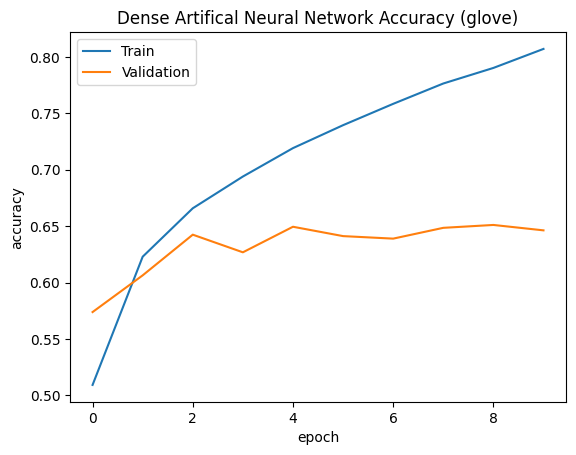

In [87]:
# summarize history for accuracy
plt.plot(average_accuracy_accross_kfold)
plt.plot(average_validation_accuracy_accross_kfold)
plt.title('Dense Artifical Neural Network Accuracy (glove)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("../outputs/feed_forward_artifical_neural_network_glove_acc.eps", format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


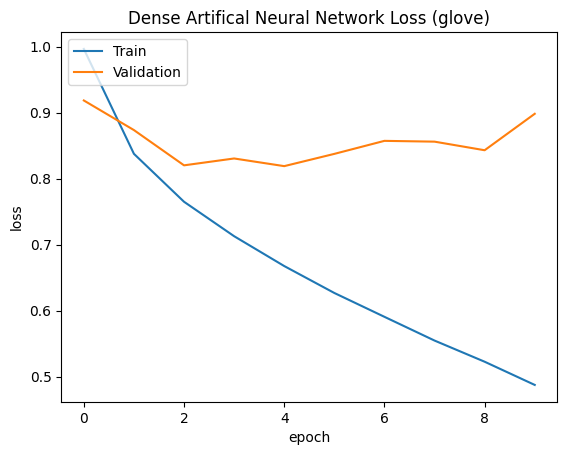

In [88]:
# summarize history for loss
plt.plot(average_loss_accross_kfold)
plt.plot(average_validation_loss_accross_kfold)
plt.title('Dense Artifical Neural Network Loss (glove)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("../outputs/feed_forward_artifical_neural_network_glove_loss.eps", format='eps')
plt.show()